In [ ]:
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 35.9 MB/s eta 0:00:00


In [ ]:
from collections import OrderedDict
from typing import Dict, Tuple
from flwr.common import NDArrays, Scalar
from torch.optim.lr_scheduler import ExponentialLR
import torch
import flwr as fl
import pickle
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(net, trainloader, optimizer, epochs, device: str, schedule):
    citertion = torch.nn.CrossEntropyLoss()
    net.train()
    net.to(device)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = citertion(net(images), labels)
            loss.backward()
            optimizer.step()
        schedule.step()


def test(net, testloader, device: str):
    citertion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    net.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            output = net(images)
            loss += citertion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct/len(testloader.dataset)
    return loss, accuracy

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, vallodaer, num_classes) -> None:
        super().__init__()
        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = LeNet(num_classes)
        # lựa chọn thiết bị để xử lý là gpu hoặc cpu
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract model parameters and return them as a list of numpy arrays."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        lr = config["lr"]
        momentum = config["momentum"]
        epochs = config["local_epochs"]
        optim = torch.optim.SGD(self.model.parameters(),
                                lr=lr)
        # Sử dụng decays exponentially rate = 0.995 để điều chỉnh learning rate
        schedule = ExponentialLR(optim, gamma=0.995)
        # Thực hiện quá trình local training
        train(self.model, self.trainloader, optim,
              epochs, self.device, schedule)

        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        self.set_parameters(parameters)

        loss, accuracy = test(self.model, self.valloader, self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}


def generate_client_fn(trainloaders, valloaders, num_classes):
    def client_fn(cid: str):
        return FlowerClient(
            trainloader=trainloaders[int(cid)],
            vallodaer=valloaders[int(cid)],
            num_classes=num_classes,
        )
    return client_fn


In [ ]:
def get_on_fit_config(lr, momentum, local_epochs, decays_exponentially):
    def fit_config_fn(server_round: int):
        return {'lr': lr, 'momentum': momentum,
                'local_epochs': local_epochs}
    return fit_config_fn


def get_evaluate_fn(num_classes: int, testloader):
    def evaluate_fn(server_round: int, parameter, config):
        model = LeNet(num_classes)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        params_dict = zip(model.state_dict().keys(), parameter)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        loss, accuracy = test(model, testloader, device)

        return loss, {'accuracy': accuracy}

    return evaluate_fn

In [ ]:
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import torch

# Chuẩn hóa dữ liệu sau đó Phân chia tập train và test

def get_mnist(data_path: str = '../data'):
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset

# Phân chia tập train và tập validate để kiểm tra model trong quá trình train

def prepare_dataset(num_partitions: int, batch_size=int, val_ratio: float = 0.1):
    trainset, testset = get_mnist()
    # slplit trainset into num_partition
    num_images = len(trainset)//num_partitions
    partition_len = [num_images] * num_partitions

    trainsets = random_split(trainset, partition_len,
                             torch.Generator().manual_seed(42))
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(
            trainset_, (num_train, num_val), torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(
            for_train, batch_size=batch_size, shuffle=False, num_workers=2))
        valloaders.append(DataLoader(
            for_val, batch_size=batch_size, shuffle=False, num_workers=2))
    testloaders = DataLoader(testset, batch_size)
    return trainloaders, valloaders, testloaders

In [ ]:
num_rounds = 5
num_clients = 40
num_clients_per_round_fit = 12
num_clients_per_round_eval = 12
num_classes = 10
batch_size = 16
lr =  0.01
momentum =  0.995
local_epochs = 5
decays_exponentially = 0.995

In [ ]:
# Prepare the dataset
trainloaders, validationloaders, testloaders = prepare_dataset(num_clients, batch_size)
print(len(trainloaders), len(trainloaders[0].dataset))

40 1350


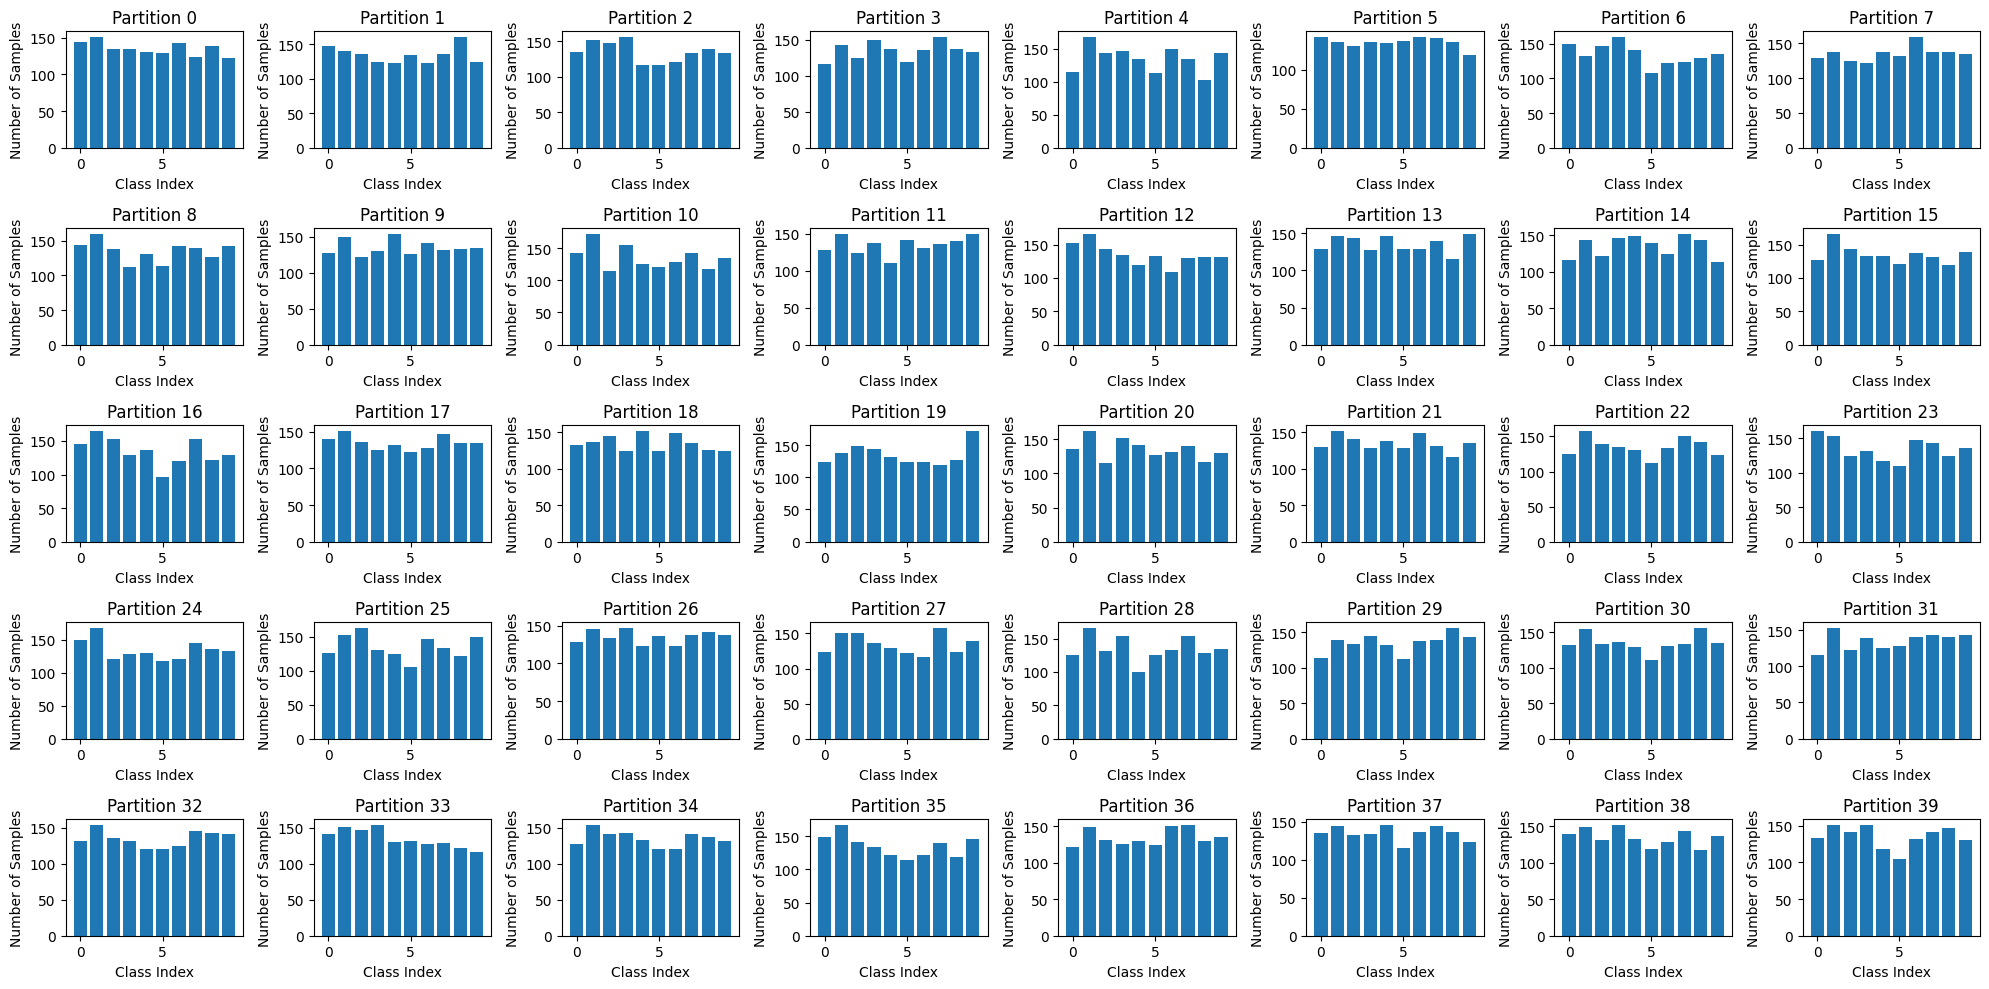

In [ ]:
import matplotlib.pyplot as plt

# Assuming trainset is your original dataset
num_partitions = len(trainloaders)

# Function to get class distribution in a dataset
def get_class_distribution(dataset):
    class_distribution = {}
    for _, label in dataset:
        if label not in class_distribution:
            class_distribution[label] = 0
        class_distribution[label] += 1
    return class_distribution

# Create a 4x8 grid of subplots
fig, axes = plt.subplots(5, 8, figsize=(20, 10))

# Plot class distribution for each partition
for i, trainloader in enumerate(trainloaders):
    dataset = trainloader.dataset
    class_distribution = get_class_distribution(dataset)

    # Convert 2D index to 1D index for subplot
    row = i // 8
    col = i % 8

    axes[row, col].bar(class_distribution.keys(), class_distribution.values())
    axes[row, col].set_title(f'Partition {i}')
    axes[row, col].set_xlabel('Class Index')
    axes[row, col].set_ylabel('Number of Samples')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# Define client
client_fn = generate_client_fn(trainloaders, validationloaders, num_classes)

# Define strategy server
strategy = fl.server.strategy.FedAvg(fraction_fit = 0.0001, min_fit_clients = num_clients_per_round_fit,
                                         fraction_evaluate=0.0001,
                                         min_evaluate_clients = num_clients_per_round_eval,
                                         min_available_clients = num_clients,
                                         on_fit_config_fn = get_on_fit_config(
                                              lr =  0.01,
                                              momentum =  0.995,
                                              local_epochs =  5,
                                              decays_exponentially = 0.995 ),
                                         evaluate_fn=get_evaluate_fn(num_classes, testloaders))

In [ ]:
# Simulation
history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
)

INFO flwr 2023-11-23 15:54:00,465 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-23 15:54:05,460	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-23 15:54:13,630 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3924631142.0, 'memory': 7849262286.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3924631142.0, 'memory': 7849262286.0, 'CPU': 2.0}
INFO flwr 2023-11-23 15:54:13,636 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-23 15:54:13,648 | app.py:224 | Flower VCE: Resources for each Virtual Clie

In [ ]:
history

History (loss, distributed):
	round 1: 10.676379765073458
	round 2: 2.698779345412428
	round 3: 1.7765668497498457
	round 4: 1.5416739621238473
	round 5: 1.2968724869036425
History (loss, centralized):
	round 0: 1441.6401364803314
	round 1: 645.1224765479565
	round 2: 159.7711840318516
	round 3: 105.33290213393047
	round 4: 83.43573290482163
	round 5: 69.23352128081024
History (metrics, centralized):
{'accuracy': [(0, 0.1033), (1, 0.7519), (2, 0.9224), (3, 0.9499), (4, 0.9604), (5, 0.9664)]}